In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot

In [4]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [5]:
n = 100 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, dirname=dn, multiTrack=multiTrack, r=True)


Importing midi-data

Encoding midi-data
 100
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [6]:
# n = 1000
# min_f = 0
# max_f = 3
# x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
#     n_polyrythms=1,
#     n_channels=3,
#     d_phase=True,
#     return_params=True,
#     dim4=dim4,
#     multiTrack=multiTrack)

In [7]:
x_train.shape

(100, 40, 10, 1)

In [8]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(100, 40, 10, 1), 90]

In [9]:
x_test = x_train[m:]
x_train = x_train[:m]

m (40, 10)


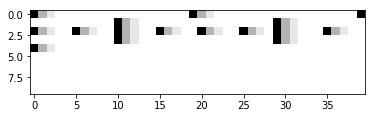

m (40, 10)


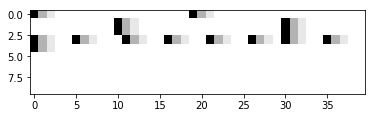

m (40, 10)


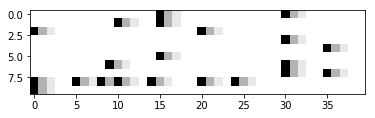

["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"]

In [10]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])
labels[0:4]

In [11]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(40, 10, 1)

In [12]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [13]:
def encoder(input_shape, dropout=0.05):
    encoder_input = Input(shape=input_shape)
    nodes = np.prod(input_shape)

    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
    shape = K.int_shape(h)[1:]
    h = Reshape(list(shape) + [1])(h)
    h = Conv2D(128, kernel_size=(2,2), strides=1, activation='relu', padding='valid')(h)
    h = MaxPooling2D((2, 1))(h)

    h = Conv2D(64, kernel_size=(2,2), strides=2, activation='relu', padding='valid')(h)
#     print(shape, list(shape))

    # Dense layers
#     h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dropout(dropout)(h) # uncomment when using larger batches
    
    h = Dense(int(nodes / 2), activation='relu')(h)
    h = Dense(intermediate_dim, activation='relu')(h)
   
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [14]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 10, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 40, 10)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 20, 32)       672         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 19, 64)       4160        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

In [15]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [16]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [17]:
def list_decoders(output_size, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_size
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    nodes = np.prod(output_shape)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
#     decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(int(nodes * 1.5), activation='relu') ]
    decoders += [ Dense(nodes, activation='relu') ]
    decoders += [ Dense(nodes, activation='relu') ]
#     decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolve & Pool
    
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
#     decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
#     decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    #     h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
#     decoders += [ Flatten()] # note that [].append != [] = []
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [18]:
decoders = list_decoders(input_shape)

In [19]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [20]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 10, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 866604      input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          384         lambda_1[0][0]                   
__________

In [21]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=1)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_3" during training.
  # This is added back by InteractiveShellApp.init_path()


In [22]:
batch_size = 100
epochs = 250
params = {'batch_size': batch_size, 'return_y': False}

In [23]:
phase_mod = 0.01
whitening = False

In [24]:
x_train.shape

(90, 40, 10, 1)

In [25]:
m = 10
useDataGenerator = False
useDataGenerator = True

# x = x_train
# x = np.stack([x_train[:m] for _ in range(10)])

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train[:m], x_train[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = x_batch
#             x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=0)
            for k,v in h.history.items(): 
                print(' \\', k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x_train[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 100

[Epoch 0/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [277.0]

[Epoch 1/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [275.0]

[Epoch 2/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [271.0]

[Epoch 3/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [266.0]

[Epoch 4/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [260.0]

[Epoch 5/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [242.0]

[Epoch 6/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [219.0]

[Epoch 7/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [189.0]

[Epoch 8/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [153.0]

[Epoch 9/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [107.0]

[Epoch 10/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [114.0]

[Epoch 11/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [146.0]

[Epoch 12/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [140.0]

[Epoch 13/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [89.0]

[Epoch 14/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [87.0]

[Epoch 15/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [74.0]

[Epoch 16/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [85.0]

[Epoch 17/250] >>>>>>>>>>>>
 Batch 0/0
 \ lo

 Batch 0/0
 \ loss [59.0]

[Epoch 149/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [56.0]

[Epoch 150/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [56.0]

[Epoch 151/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [56.0]

[Epoch 152/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [59.0]

[Epoch 153/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [57.0]

[Epoch 154/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [57.0]

[Epoch 155/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [56.0]

[Epoch 156/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [57.0]

[Epoch 157/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [56.0]

[Epoch 158/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [58.0]

[Epoch 159/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [55.0]

[Epoch 160/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [58.0]

[Epoch 161/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [58.0]

[Epoch 162/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [57.0]

[Epoch 163/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [57.0]

[Epoch 164/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [57.0]

[Epoch 165/250] >>>>>>>>>>>>
 Batch 0/0
 \ loss [57.0]

[Epoch 166/250] >>>>>

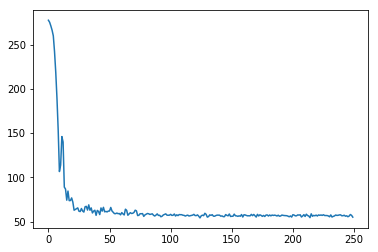

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

m (40, 10)


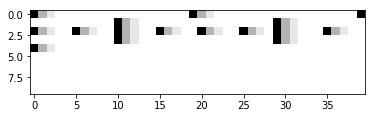

m (40, 10)


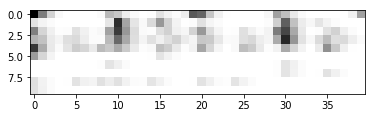

m (40, 10)


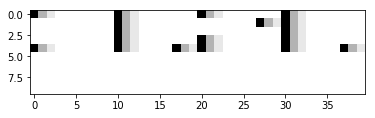

m (40, 10)


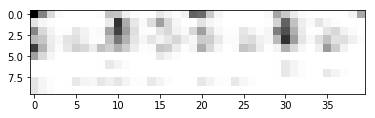

m (40, 10)


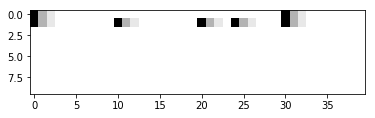

m (40, 10)


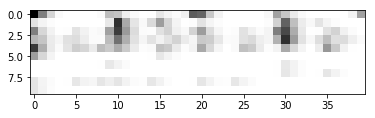

In [27]:
i = 0
j = 30
k = -1
x = vae.predict(x_train[:100])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(x_train[k, :50, :, 0])
plot.single(x[k, :50, :, 0])

In [28]:
x.shape

(90, 40, 10, 1)

m (30, 10)


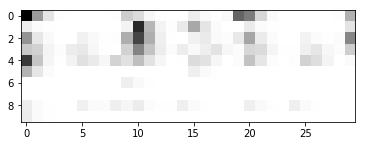

In [29]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 10)


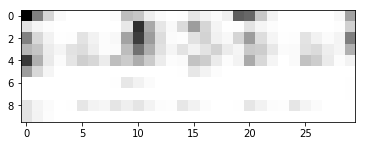

In [30]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [31]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [32]:
x_test.shape

(10, 40, 10, 1)

In [33]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(90, 2)

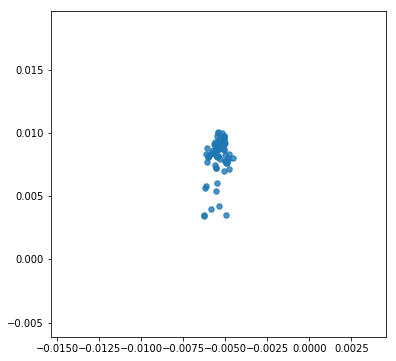

In [34]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.8, s=30) # c=y_test, 

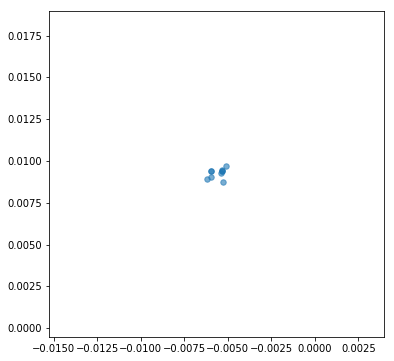

In [35]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.6, s=30) # , c=y_test
# plt.colorbar()

In [36]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [37]:
# x_decoded[0].reshape(150,3)

In [38]:
x_train.shape

(90, 40, 10, 1)

(2,) [0. 0.]


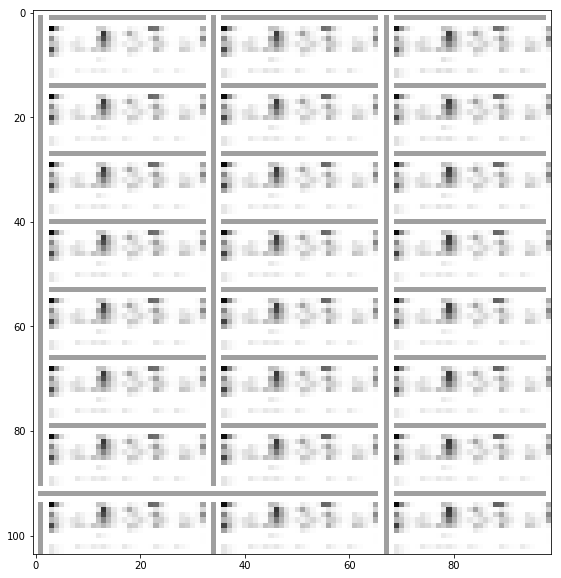

In [39]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(2,) [0. 0.]


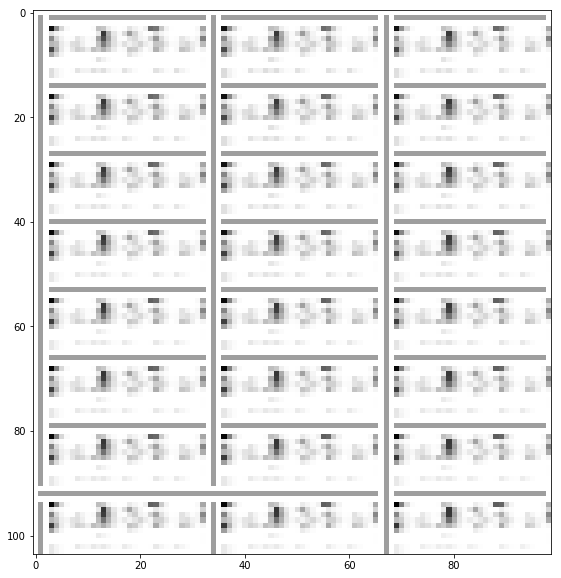

In [40]:
min_y2 = max_y
plot.latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)